In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import torch
import pathlib
import numpy as np
import pandas as pd

dim = 16
directory = pathlib.Path("../events/MG3")

df3b = pd.read_hdf(directory / "dataframes" / "bbbj.h5")
df4b = pd.read_hdf(directory / "dataframes" / "bbbb_large.h5")

In [8]:
import sys
sys.path.append("/home/soheuny/HH4bsim/python/classifier/")
from symmetrize_df import symmetrize_df

df3b = symmetrize_df(df3b)
df4b = symmetrize_df(df4b)

In [9]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from symmetrized_model_train import symmetrizedModelParameters

model_config = "FvT_ResNet_6_6_6_np799_lr0.01_epochs30_stdscale_epoch30_loss0.6703.pkl"

model_filename = f"/home/soheuny/HH4bsim/python/classifier/FvT/fvt_fit/archive/{model_config}"
clf = symmetrizedModelParameters(df3b, df4b, fileName=model_filename)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

X_train = torch.tensor(clf.df_train[features].values, dtype=torch.float32)
X_validation = torch.tensor(clf.df_val[features].values, dtype=torch.float32)

y_train = torch.tensor(clf.df_train["d4"].values, dtype=torch.float32)
y_validation = torch.tensor(clf.df_val["d4"].values, dtype=torch.float32)

Add true class labels to data
concatenate data and ttbar dataframes
add encoded target
nd4 =  382108, wd4 = 385679.3
nd3 =  275508, wd3 = 279203.5
fC: tensor([0.5801, 0.4199])
build idx with offset 0, modulus 3, and train/val split 2
Split into training and validation sets
--------------- LRINIT:  0.01
cuda
Set log file: log_file.log
SymmetrizedResNet(
  (canJetScaler): scaler()
  (dijetScaler): scaler()
  (quadjetScaler): scaler()
  (jetPtGBN): GhostBatchNorm1d()
  (jetEtaGBN): GhostBatchNorm1d()
  (jetMassGBN): GhostBatchNorm1d()
  (jetEmbed): conv1d(
    (module): Conv1d(4, 6, kernel_size=(1,), stride=(1,))
  )
  (dijetGBN): GhostBatchNorm1d()
  (dijetEmbed1): conv1d(
    (module): Conv1d(2, 6, kernel_size=(1,), stride=(1,))
  )
  (dijetResNetBlock): dijetResNetBlock(
    (reinforce1): dijetReinforceLayer(
      (conv): conv1d(
        (module): Conv1d(6, 6, kernel_size=(3,), stride=(3,), bias=False)
        (batchNorm): GhostBatchNorm1d()
      )
    )
    (convJ): conv1d(
      (m

In [10]:
from fvt_eval import calculate_fvt_values

loss, grads, scores = calculate_fvt_values(clf, clf.df_val)
# ResNet predictions
probs_4b_sym_resnet = torch.softmax(scores, dim=1)[:, 1].detach()
# cross check
weights = clf.df_val[clf.weight].values
loss_val_crosscheck = -torch.sum((torch.log(probs_4b_sym_resnet) * y_validation 
                               + torch.log(1 - probs_4b_sym_resnet) * (1 - y_validation)) * weights) / np.sum(weights)

print("SymResNet Validation Loss: ", loss)
print("SymResNet Validation Loss Cross check: ", loss_val_crosscheck)

# without gradients
X_validation = torch.cat((X_validation, probs_4b_sym_resnet.reshape(-1, 1)), dim=1)

# with gradients
# remove the gradient of sym_canJet0_phi
# grads = grads[:, np.arange(grads.shape[1]) != 8]
# X_validation = torch.cat((X_validation, probs_4b_sym_resnet.reshape(-1, 1), 
#                           grads.reshape(-1, X_validation.shape[1])), dim=1)

SymResNet Validation Loss:  0.6703050996648615
SymResNet Validation Loss Cross check:  tensor(0.6703)


In [4]:
from autoencoder import Autoencoder 
import pytorch_lightning as pl

pl.seed_everything(42)
hidden_dims = [256] * 8
model = Autoencoder(input_dim=X_validation.shape[1], 
                    latent_dim=15, 
                    run_name_base="naive_mlp_ae",
                    hidden_dims=hidden_dims, lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# split X_validation into training and validation
random_indices = torch.randperm(len(X_validation))

train_indices = random_indices[:int((2/3) * len(X_validation))]
validation_indices = random_indices[int((2/3) * len(X_validation)):]

X_ae_train = X_validation[train_indices]
X_ae_validation = X_validation[validation_indices]
y_ae_train = y_validation[train_indices]
y_ae_validation = y_validation[validation_indices]

model.set_loss_weights(1 / torch.var(X_ae_train, dim=0))
model.fit(X_ae_train, X_ae_validation, batch_size=2**9, max_epochs=10)

Seed set to 42


NameError: name 'X_validation' is not defined

In [19]:
model_checkpoint_path = "./checkpoints/naive_mlp_ae_best-v4.ckpt"
model = Autoencoder.load_from_checkpoint(checkpoint_path=model_checkpoint_path)
model.set_loss_weights(1 / torch.var(X_ae_train, dim=0))

model.eval()
X_ae_validation = X_ae_validation.to(device)
X_ae_validation_encoded = model.encode(X_ae_validation)
X_ae_validation_decoded = model.decode(X_ae_validation_encoded)

X_ae_validation_np = X_ae_validation.detach().cpu().numpy()
X_ae_validation_encoded_np = X_ae_validation_encoded.detach().cpu().numpy()
X_ae_validation_decoded_np = X_ae_validation_decoded.detach().cpu().numpy()
y_ae_validation_np = y_ae_validation.detach().cpu().numpy()

X_ae_train = X_ae_train.to(device)
X_ae_train_encoded = model.encode(X_ae_train)
X_ae_train_decoded = model.decode(X_ae_train_encoded)

X_ae_train_np = X_ae_train.detach().cpu().numpy()
X_ae_train_encoded_np = X_ae_train_encoded.detach().cpu().numpy()
X_ae_train_decoded_np = X_ae_train_decoded.detach().cpu().numpy()
y_ae_train_np = y_ae_train.detach().cpu().numpy()

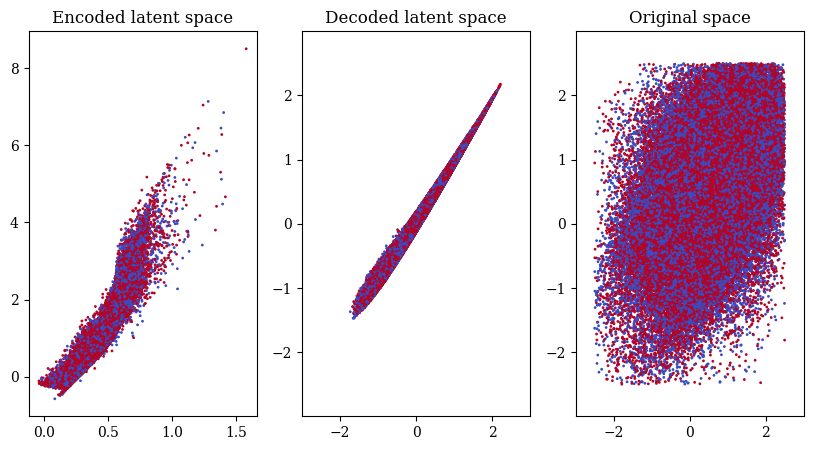

In [21]:
# plot latent space
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


%matplotlib inline
f1 = 5
f2 = 6

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.scatter(X_ae_validation_encoded_np[:, 0], X_ae_validation_encoded_np[:, 1], 
            c=y_ae_validation_np, cmap="coolwarm", s=1)
plt.title("Encoded latent space")

xmin, xmax = X_ae_validation_decoded_np[:, f1].min(), X_ae_validation_decoded_np[:, f1].max()
xmin, xmax = min(xmin, X_ae_validation_np[:, f1].min()), max(xmax, X_ae_validation_np[:, f1].max())
ymin, ymax = X_ae_validation_decoded_np[:, f2].min(), X_ae_validation_decoded_np[:, f2].max()
ymin, ymax = min(ymin, X_ae_validation_np[:, f2].min()), max(ymax, X_ae_validation_np[:, f2].max())
x_diff = ymax - ymin
y_diff = xmax - xmin
ymin, ymax = ymin - 0.1 * x_diff, ymax + 0.1 * x_diff
xmin, xmax = xmin - 0.1 * y_diff, xmax + 0.1 * y_diff

plt.subplot(132)
plt.scatter(X_ae_validation_decoded_np[:, f1], X_ae_validation_decoded_np[:, f2], 
            c=y_ae_validation_np, cmap="coolwarm", s=1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Decoded latent space")

plt.subplot(133)
plt.scatter(X_ae_validation_np[:, f1], X_ae_validation_np[:, f2], 
            c=y_ae_validation_np, cmap="coolwarm", s=1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Original space")
plt.show()
plt.close()

# plt.figure(figsize=(10, 5))
# plt.subplot(131)
# plt.scatter(X_ae_train_encoded_np[:, 0], X_ae_train_encoded_np[:, 1], 
#             c=y_ae_train_np, cmap="coolwarm", s=1)
# plt.title("Encoded latent space")

# xmin, xmax = X_ae_train_decoded_np[:, f1].min(), X_ae_train_decoded_np[:, f1].max()
# xmin, xmax = min(xmin, X_ae_train_np[:, f1].min()), max(xmax, X_ae_train_np[:, f1].max())
# ymin, ymax = X_ae_train_decoded_np[:, f2].min(), X_ae_train_decoded_np[:, f2].max()
# ymin, ymax = min(ymin, X_ae_train_np[:, f2].min()), max(ymax, X_ae_train_np[:, f2].max())
# x_diff = ymax - ymin
# y_diff = xmax - xmin
# ymin, ymax = ymin - 0.1 * x_diff, ymax + 0.1 * x_diff
# xmin, xmax = xmin - 0.1 * y_diff, xmax + 0.1 * y_diff

# plt.subplot(132)
# plt.scatter(X_ae_train_decoded_np[:, f1], X_ae_train_decoded_np[:, f2], 
#             c=y_ae_train_np, cmap="coolwarm", s=1)
# plt.title("Decoded latent space")
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
# plt.subplot(133)
# plt.scatter(X_ae_train_np[:, f1], X_ae_train_np[:, f2], 
#             c=y_ae_train_np, cmap="coolwarm", s=1)
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
# plt.title("Original space")
# plt.show()
# plt.close()

In [51]:
df_decoded = pd.DataFrame(X_ae_validation_decoded_np, 
             columns=features + ["probs_4b_sym_resnet"] + [f"grad_{f}" for f in features])
df_decoded.describe()

,sym_canJet0_pt,sym_canJet1_pt,sym_canJet2_pt,sym_canJet3_pt,sym_canJet0_eta,sym_canJet1_eta,sym_canJet2_eta,sym_canJet3_eta,sym_canJet0_phi,sym_canJet1_phi,...,grad_sym_canJet2_eta,grad_sym_canJet3_eta,grad_sym_canJet0_phi,grad_sym_canJet1_phi,grad_sym_canJet2_phi,grad_sym_canJet3_phi,grad_sym_canJet0_m,grad_sym_canJet1_m,grad_sym_canJet2_m,grad_sym_canJet3_m
count,73069.000000,73069.000000,73069.000000,73069.000000,7.306900e+04,7.306900e+04,7.306900e+04,7.306900e+04,7.306900e+04,7.306900e+04,...,7.306900e+04,7.306900e+04,7.306900e+04,7.306900e+04,73069.000000,7.306900e+04,73069.000000,7.306900e+04,7.306900e+04,7.306900e+04
mean,98.279472,76.232574,58.885521,49.220139,-4.520496e-07,-3.796484e-07,-3.193509e-07,-5.363513e-07,-4.786035e-05,-2.502089e-07,...,-2.932038e-07,-8.910427e-07,-5.129372e-06,-1.934524e-02,-0.021682,-4.454705e-06,0.031900,-7.904498e-06,-2.353530e-05,-5.514004e-07
std,35.496597,25.550720,13.325168,6.642663,1.850643e-06,1.711619e-06,1.369185e-06,2.227704e-06,1.116598e-04,1.041685e-06,...,1.161489e-06,3.160982e-06,1.198433e-05,1.647421e-02,0.022473,1.682501e-05,0.080102,2.197566e-05,1.093651e-04,2.192796e-06
min,46.019722,43.222176,38.878567,37.785278,-5.793128e-05,-5.862475e-05,-4.422083e-05,-6.779196e-05,-2.061532e-03,-3.354907e-05,...,-3.557675e-05,-8.799863e-05,-1.992350e-04,-9.988291e-02,-0.278450,-4.771326e-04,-0.278465,-5.322492e-04,-3.344543e-03,-6.702140e-05
25%,76.429451,61.829159,50.680099,44.897232,-1.613498e-07,-1.191795e-07,-1.107868e-07,-1.894421e-07,-4.238473e-05,-9.021891e-08,...,-1.241171e-07,-4.426012e-07,-4.446899e-06,-2.869821e-02,-0.032809,-1.925233e-06,0.003638,-5.331076e-06,-5.238534e-06,-2.243339e-07
50%,89.842911,70.053894,55.940075,47.688248,-1.275805e-08,-1.024673e-08,-1.001645e-08,-1.689100e-08,-8.939703e-06,-7.712681e-09,...,-1.287906e-08,-5.147649e-08,-7.296536e-07,-1.519980e-02,-0.020109,-1.903662e-07,0.058871,-5.883435e-07,-2.428946e-07,-2.213084e-08
75%,109.269562,81.865616,63.021214,51.830864,-3.139907e-10,-3.129693e-10,-3.356568e-10,-5.520913e-10,-9.879618e-07,-2.384297e-10,...,-5.411377e-10,-2.480681e-09,-4.334416e-08,-6.210507e-03,-0.013387,-6.462506e-09,0.089420,-7.041418e-09,-2.237330e-09,-8.930869e-10
max,688.418030,587.384277,273.904694,150.711731,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-5.748925e-19,0.144254,-0.000000e+00,0.111067,-0.000000e+00,-0.000000e+00,-0.000000e+00


In [54]:
clf.df_val.iloc[validation_indices].describe()

,canJet0_pt,canJet1_pt,canJet2_pt,canJet3_pt,canJet0_eta,canJet1_eta,canJet2_eta,canJet3_eta,canJet0_phi,canJet1_phi,...,sym_canJet1_pt,sym_canJet1_m,sym_canJet2_pt,sym_canJet2_m,sym_canJet3_pt,sym_canJet3_m,d3,pseudoTagWeight,mcPseudoTagWeight,target
count,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,...,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,73069.000000,73069.0,73069.000000,73069.000000
mean,98.717606,76.710007,60.216496,49.470810,-0.000304,-0.001757,-0.000506,-0.002476,-0.005531,0.008140,...,76.710007,-0.000101,60.216496,-0.000095,49.470810,-0.000235,0.417359,1.0,1.011181,0.417359
std,35.749016,25.818430,14.242452,8.943587,1.095348,1.086880,1.085310,1.092918,1.813205,1.813694,...,25.818430,0.047394,14.242452,0.036376,8.943587,0.030082,0.493127,0.0,0.080483,0.493127
min,45.070866,41.083698,40.167580,40.000000,-2.498940,-2.499513,-2.499607,-2.498676,-3.141528,-3.141533,...,41.083698,-0.520365,40.167580,-0.280693,40.000000,-0.244600,0.000000,1.0,0.763009,0.000000
25%,76.752274,62.023483,51.392044,43.527325,-0.849461,-0.811768,-0.799043,-0.805415,-1.573127,-1.554971,...,62.023483,-0.024703,51.392044,-0.018872,43.527325,-0.015757,0.000000,1.0,0.969409,0.000000
50%,90.181389,70.624611,57.265953,47.383858,0.002356,-0.001413,-0.003258,-0.000382,-0.009381,0.019974,...,70.624611,0.001987,57.265953,-0.001344,47.383858,-0.001641,0.000000,1.0,1.001588,0.000000
75%,109.617630,82.732513,64.912987,52.753956,0.849493,0.807242,0.794678,0.794556,1.571219,1.578858,...,82.732513,0.024718,64.912987,0.018808,52.753956,0.015548,1.000000,1.0,1.036727,1.000000
max,703.999084,666.670044,301.997620,259.037170,2.498522,2.499233,2.499982,2.499032,3.141420,3.141503,...,666.670044,0.460649,301.997620,0.295394,259.037170,0.284315,1.000000,1.0,2.969383,1.000000


sym_resnet


/home/soheuny/HH4bsim/playground/plots.py:46: RuntimeWarning: divide by zero encountered in divide
  ratio_mean = hist_4b / w_hist_3b
/home/soheuny/HH4bsim/playground/plots.py:46: RuntimeWarning: invalid value encountered in divide
  ratio_mean = hist_4b / w_hist_3b
/home/soheuny/HH4bsim/playground/plots.py:48: RuntimeWarning: divide by zero encountered in divide
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2
/home/soheuny/HH4bsim/playground/plots.py:48: RuntimeWarning: invalid value encountered in multiply
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2
/home/soheuny/HH4bsim/playground/plots.py:48: RuntimeWarning: invalid value encountered in divide
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2


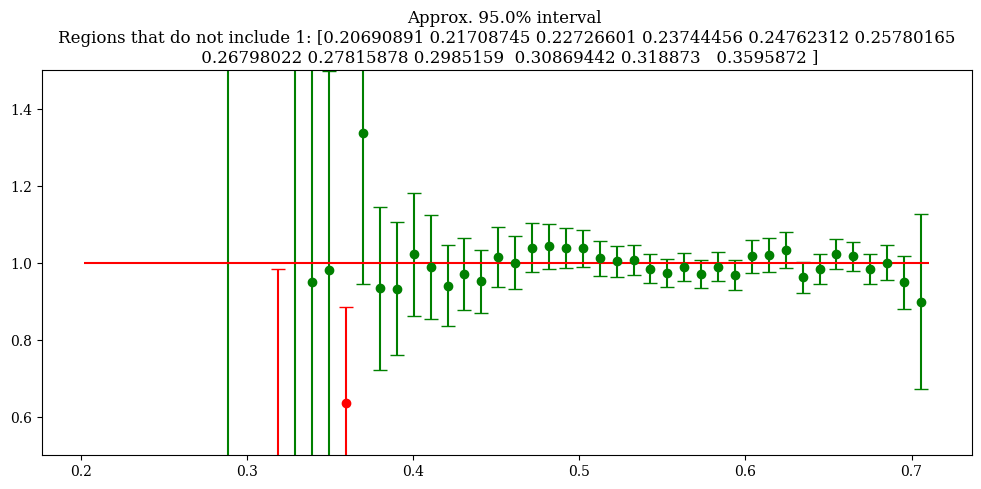

In [16]:
from plots import plot_prob_weighted_histogram1d, plot_prob_weighted_histogram2d
%matplotlib inline
labels_4b = clf.df_val[clf.yTrueLabel].values

for clf_type in ["sym_resnet"]:
    print(clf_type)
    probs_4b = eval(f"probs_4b_{clf_type}")
    plot_feature_arr = probs_4b
    plot_prob_weighted_histogram1d(probs_4b, plot_feature_arr, labels_4b,
                                    n_bins=50, 
                                    output_file="figures/weighted_hist_1d_{}_features_{}.pdf".format(
                                    clf_type, "probs_4b"), 
                                    sample_weights=weights,
                                    ylim=(0.5, 1.5))

sym_resnet


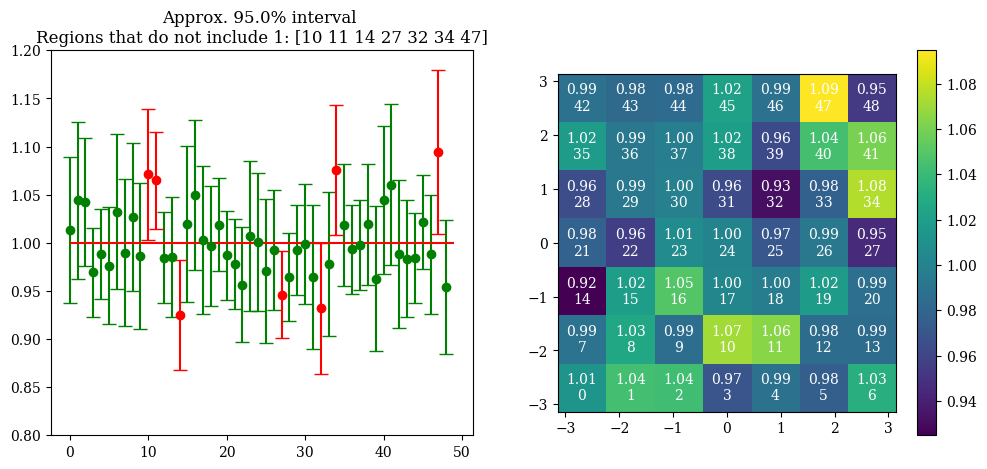

In [17]:
plot_features=["canJet0_phi", "canJet1_phi"]
for clf_type in ["sym_resnet"]:
    print(clf_type)
    probs_4b = eval(f"probs_4b_{clf_type}")
    plot_prob_weighted_histogram2d(probs_4b, clf.df_val, 
                                plot_features=plot_features, 
                                n_bins=7, 
                                output_file="figures/weighted_hist_2d_{}_features_{}.pdf".format(
                                    clf_type, "_".join(plot_features)), 
                                    ylim=(0.8, 1.2))
    

Symmetrized ResNet


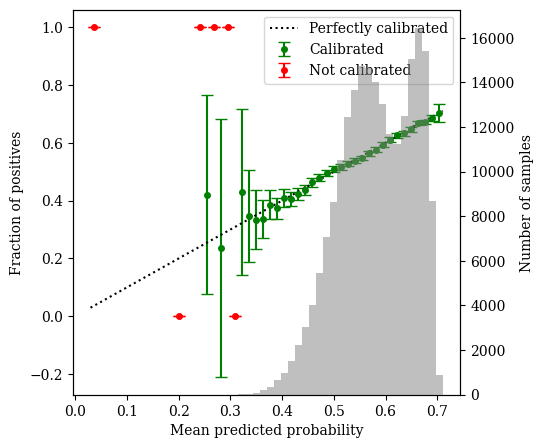

0.5799232


In [18]:
# Calibration plot
from plots import calibration_plot

%matplotlib inline

print("Symmetrized ResNet")
calibration_plot(probs_4b_sym_resnet, 
                 y_validation.detach().numpy(), 
                 bins=50,
                 sample_weights=clf.df_val[clf.weight].values
                 )
print(clf.df_val.loc[clf.df_val["fourTag"], clf.weight].sum() / clf.df_val[clf.weight].sum())

Make data loader
Evaluating 100%     Symmetrized ResNet -- Training Data


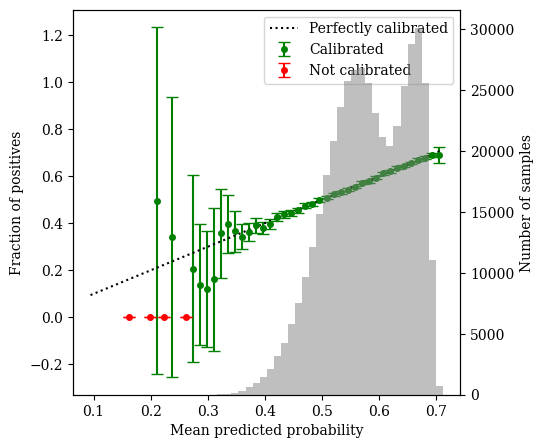

0.5801452


In [19]:
# Training Data
probs_train, _ = clf.predict(clf.df_train)
probs_4b_train = probs_train[:, 1]

%matplotlib inline

print("Symmetrized ResNet -- Training Data")
calibration_plot(probs_4b_train, 
                 y_train.detach().numpy(), 
                 bins=50,
                 sample_weights=clf.df_train[clf.weight].values
                 )
print(clf.df_train.loc[clf.df_train["fourTag"], clf.weight].sum() / clf.df_train[clf.weight].sum())

In [20]:
clf.df_val[features].describe()

,sym_canJet0_pt,sym_canJet1_pt,sym_canJet2_pt,sym_canJet3_pt,sym_canJet0_eta,sym_canJet1_eta,sym_canJet2_eta,sym_canJet3_eta,sym_canJet0_phi,sym_canJet1_phi,sym_canJet2_phi,sym_canJet3_phi,sym_canJet0_m,sym_canJet1_m,sym_canJet2_m,sym_canJet3_m
count,219205.000000,219205.000000,219205.000000,219205.000000,2.192050e+05,219205.000000,219205.000000,219205.000000,219205.0,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000
mean,98.851921,76.723633,60.265198,49.448959,9.185196e-01,0.502468,0.523196,0.519336,0.0,1.925889,-0.386150,-0.373678,0.000256,0.000039,0.000038,-0.000187
std,35.581348,25.722361,14.296140,8.886579,5.947842e-01,0.965643,0.950737,0.965777,0.0,0.922796,2.046143,2.103512,0.059593,0.047828,0.036482,0.030209
min,43.626026,40.712936,40.050472,40.000000,9.124323e-07,-2.499619,-2.498249,-2.499891,0.0,0.000040,-3.141576,-3.141589,-0.844628,-0.992282,-0.433601,-0.304064
25%,76.760628,62.041908,51.391399,43.478271,4.154071e-01,-0.152567,-0.118243,-0.136906,0.0,1.224401,-2.213035,-2.255540,-0.031034,-0.024667,-0.018868,-0.015718
50%,90.250549,70.600296,57.264973,47.333164,8.529556e-01,0.557579,0.568989,0.560867,0.0,2.161495,-0.894047,-0.990852,0.002595,0.001636,0.000454,-0.001416
75%,109.937828,82.776497,64.992844,52.770676,1.361931e+00,1.223433,1.225924,1.232047,0.0,2.716658,1.792771,1.982849,0.031296,0.024754,0.018932,0.015562
max,795.480530,722.779358,315.974274,259.037170,2.499404e+00,2.499988,2.499982,2.499912,0.0,3.141572,3.141587,3.141567,0.854470,0.760168,0.428674,0.352329


In [21]:

import matplotlib.pyplot as plt
import scipy.spatial.distance

%matplotlib inline

# normalize X_validation
features_tmp = ["canJet0_pt", "canJet1_pt", "canJet2_pt", "canJet3_pt",
                "canJet0_eta", "canJet1_eta", "canJet2_eta", "canJet3_eta",
                "canJet1_phi", "canJet2_phi", "canJet3_phi",
                "canJet0_m", "canJet1_m", "canJet2_m", "canJet3_m"]
normalized_X_val = clf.df_val[features_tmp].values
normalized_X_val = (normalized_X_val - np.mean(normalized_X_val, axis=0)) / np.std(normalized_X_val, axis=0)
is_4b = clf.df_val["fourTag"].values
weights = clf.df_val[clf.weight].values

n_pick = 20000
print("Total 4b ratio: ", np.sum(weights * is_4b) / np.sum(weights))

# shuffle and randomly pick n_pick samples
rand_idx = np.random.permutation(normalized_X_val.shape[0])[:n_pick]
normalized_X_val = normalized_X_val[rand_idx]
is_4b = is_4b[rand_idx]
weights = weights[rand_idx]
probs_4b_est = probs_4b_sym_resnet[rand_idx]

# calculate pairwise distance of normalized_X_val
dist = scipy.spatial.distance.cdist(normalized_X_val, normalized_X_val)

alpha_nearest = 0.01
n_nearest = int(n_pick * alpha_nearest)
ratio_4b = np.zeros(n_pick)
ratio_4b_est = np.zeros(n_pick)
for idx in range(normalized_X_val.shape[0]):
    nearest_idx = np.argsort(dist[idx])[:n_nearest]
    ratio_4b[idx] = np.sum(is_4b[nearest_idx] * weights[nearest_idx]) / np.sum(weights[nearest_idx])

Total 4b ratio:  0.5799232


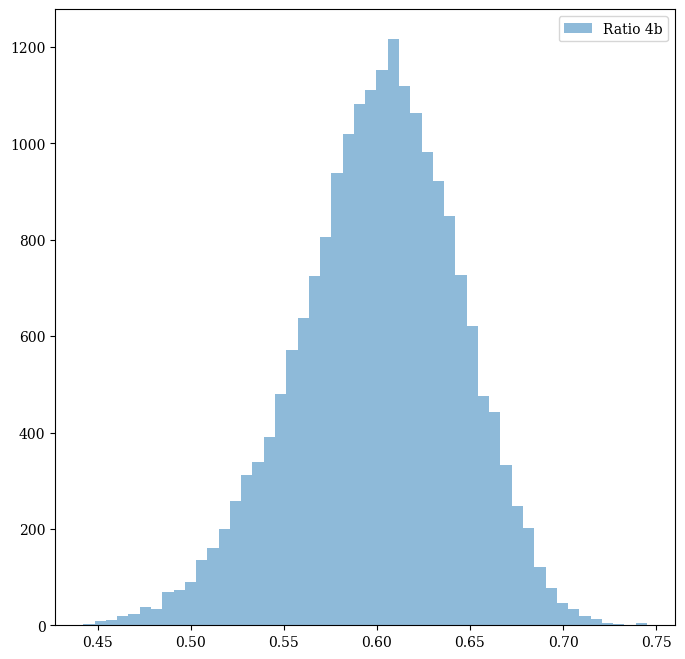

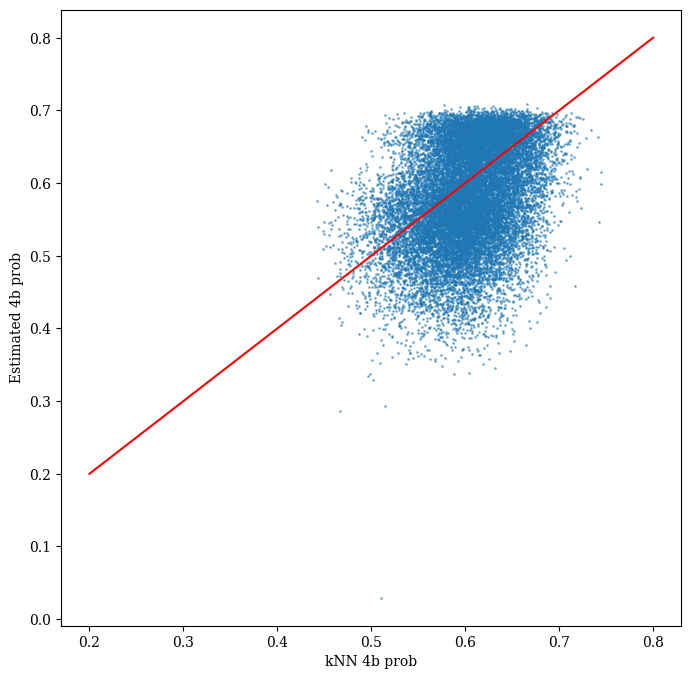

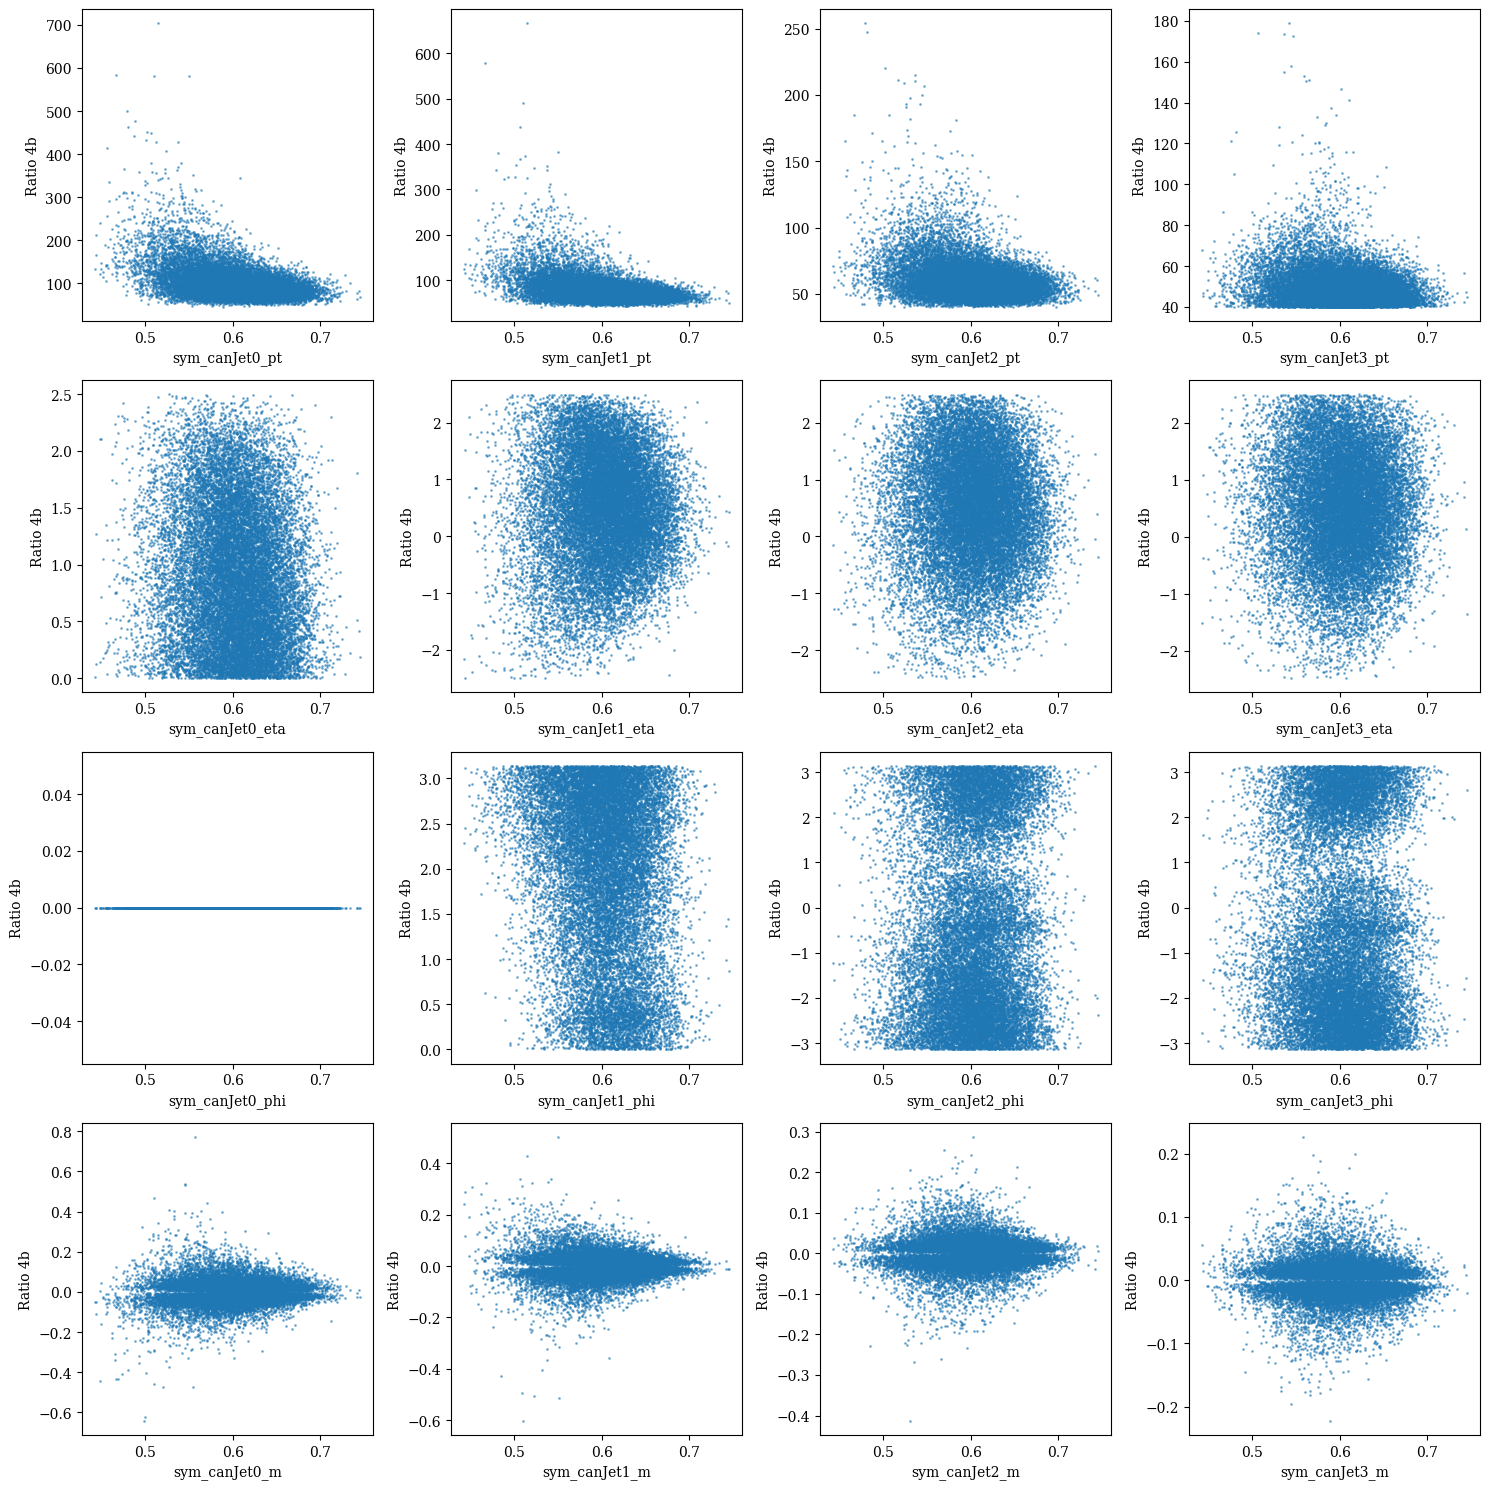

In [22]:
%matplotlib inline

plt.hist(ratio_4b, bins=50, alpha=0.5, label="Ratio 4b", weights=weights)
plt.legend()
plt.show()
plt.close()

plt.scatter(ratio_4b, probs_4b_est, alpha=0.5, s=1)
plt.xlabel("kNN 4b prob")
plt.ylabel("Estimated 4b prob")
plt.plot([0.2, 0.8], [0.2, 0.8], color="red")
plt.show()
plt.close()

fig, ax = plt.subplots(4, 4, figsize=(15, 15))
ax_cnt = 0
for i, feature in enumerate(features):
    current_ax = ax[i // 4, i % 4]
    current_ax.scatter(ratio_4b, clf.df_val[feature].values[rand_idx], alpha=0.5, s=1)
    current_ax.set_xlabel(feature)
    current_ax.set_ylabel("Ratio 4b")
plt.tight_layout()
plt.show()
plt.close()

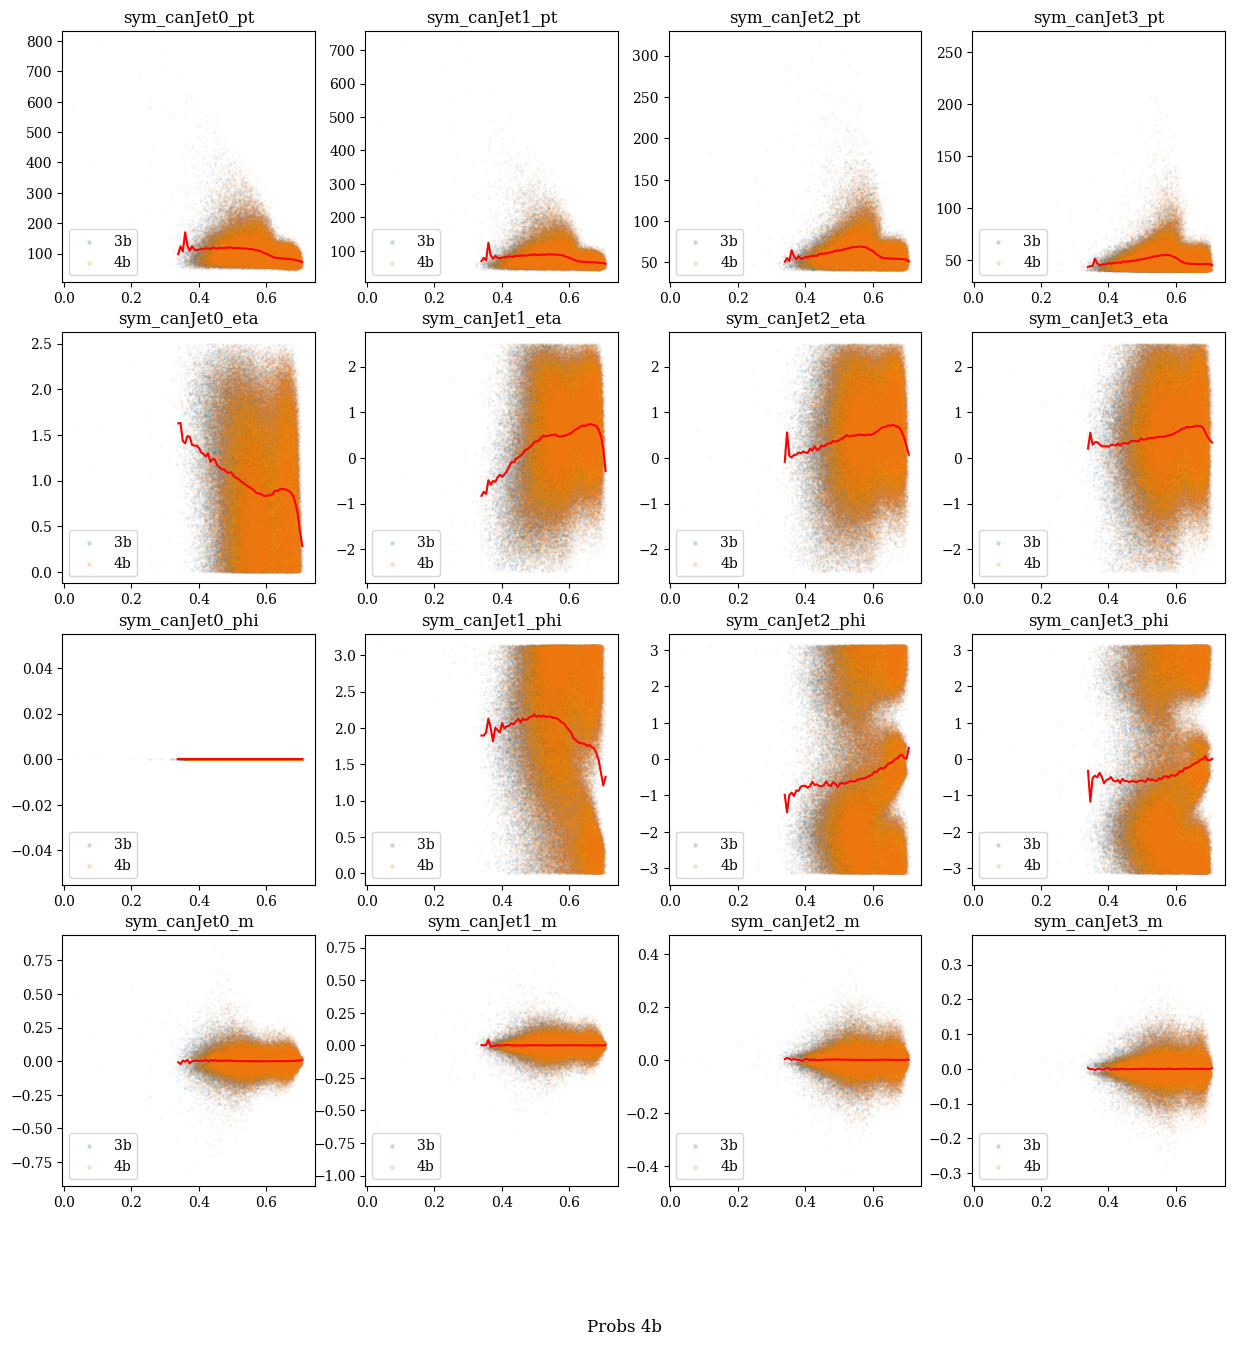

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
ax_cnt = 0
fig.supxlabel("Probs 4b")
bins = 100

prob_min, prob_max = min(probs_4b_sym_resnet), max(probs_4b_sym_resnet)
xs = np.linspace(prob_min, prob_max, bins + 1)
weights = clf.df_val[clf.weight].values
is_4b = clf.df_val["fourTag"]
    

for feature in features:
    feature_arr = clf.df_val[feature]
    
    current_ax = ax[ax_cnt // 4, ax_cnt % 4]
    
    # scatter 3b
    current_ax.scatter(probs_4b_sym_resnet[~is_4b], feature_arr[~is_4b], alpha=0.2, s=0.05, label="3b")
    # scatter 4b
    current_ax.scatter(probs_4b_sym_resnet[is_4b], feature_arr[is_4b], alpha=0.2, s=0.05, label="4b")
    current_ax.set_title(feature)

    avg_arr = np.zeros(bins)

    for i in range(bins):
        is_in_bin = (probs_4b_sym_resnet >= xs[i]) & (probs_4b_sym_resnet < xs[i + 1])
        if is_in_bin.sum() < 1e1:
            avg_arr[i] = np.nan
            continue
        avg_arr[i] = np.mean(feature_arr[is_in_bin] * weights[is_in_bin])

    current_ax.plot((xs[1:] + xs[:-1]) / 2, avg_arr, color="red")
    # larger marker for legend
    current_ax.legend(markerscale=10, loc="lower left")
    ax_cnt += 1

plt.show()
plt.close()

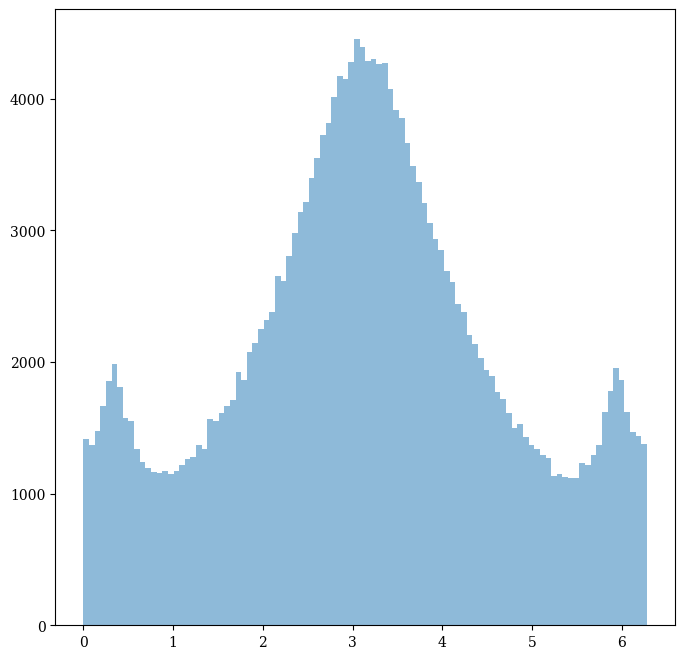

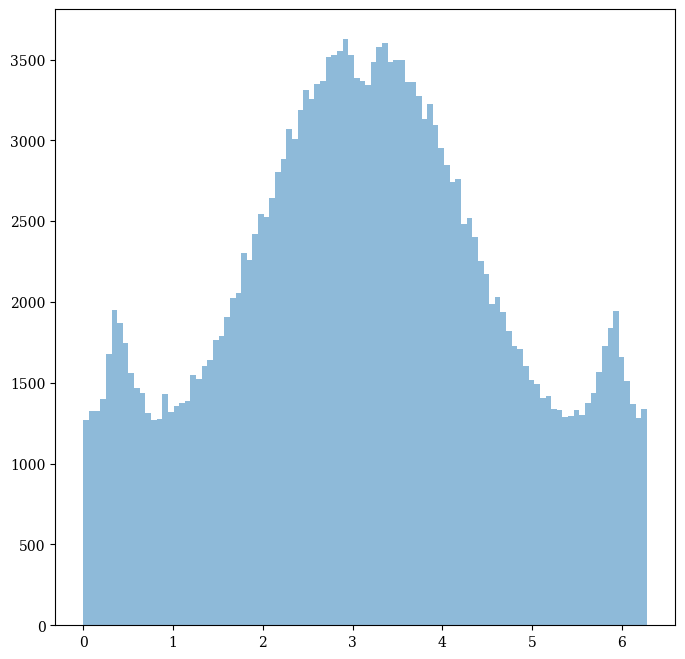

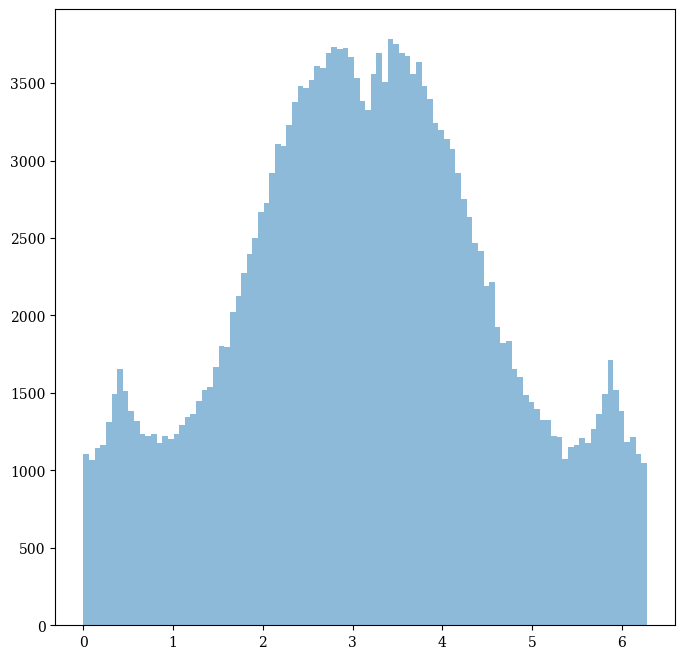

In [24]:
plt.hist(clf.df_val.eval("canJet1_phi - canJet0_phi") % (2 * np.pi), bins=100, alpha=0.5, weights=clf.df_val[clf.weight].values)
plt.show()
plt.hist(clf.df_val.eval("canJet2_phi - canJet0_phi") % (2 * np.pi), bins=100, alpha=0.5, weights=clf.df_val[clf.weight].values)
plt.show()
plt.hist(clf.df_val.eval("canJet3_phi - canJet0_phi") % (2 * np.pi), bins=100, alpha=0.5, weights=clf.df_val[clf.weight].values)
plt.show()
plt.close()

/tmp/ipykernel_1519733/4086042191.py:18: RuntimeWarning: invalid value encountered in scalar divide
  probs_4b_arr[i] = (is_4b[is_in_bin] * weights[is_in_bin]).sum() / weights[is_in_bin].sum()


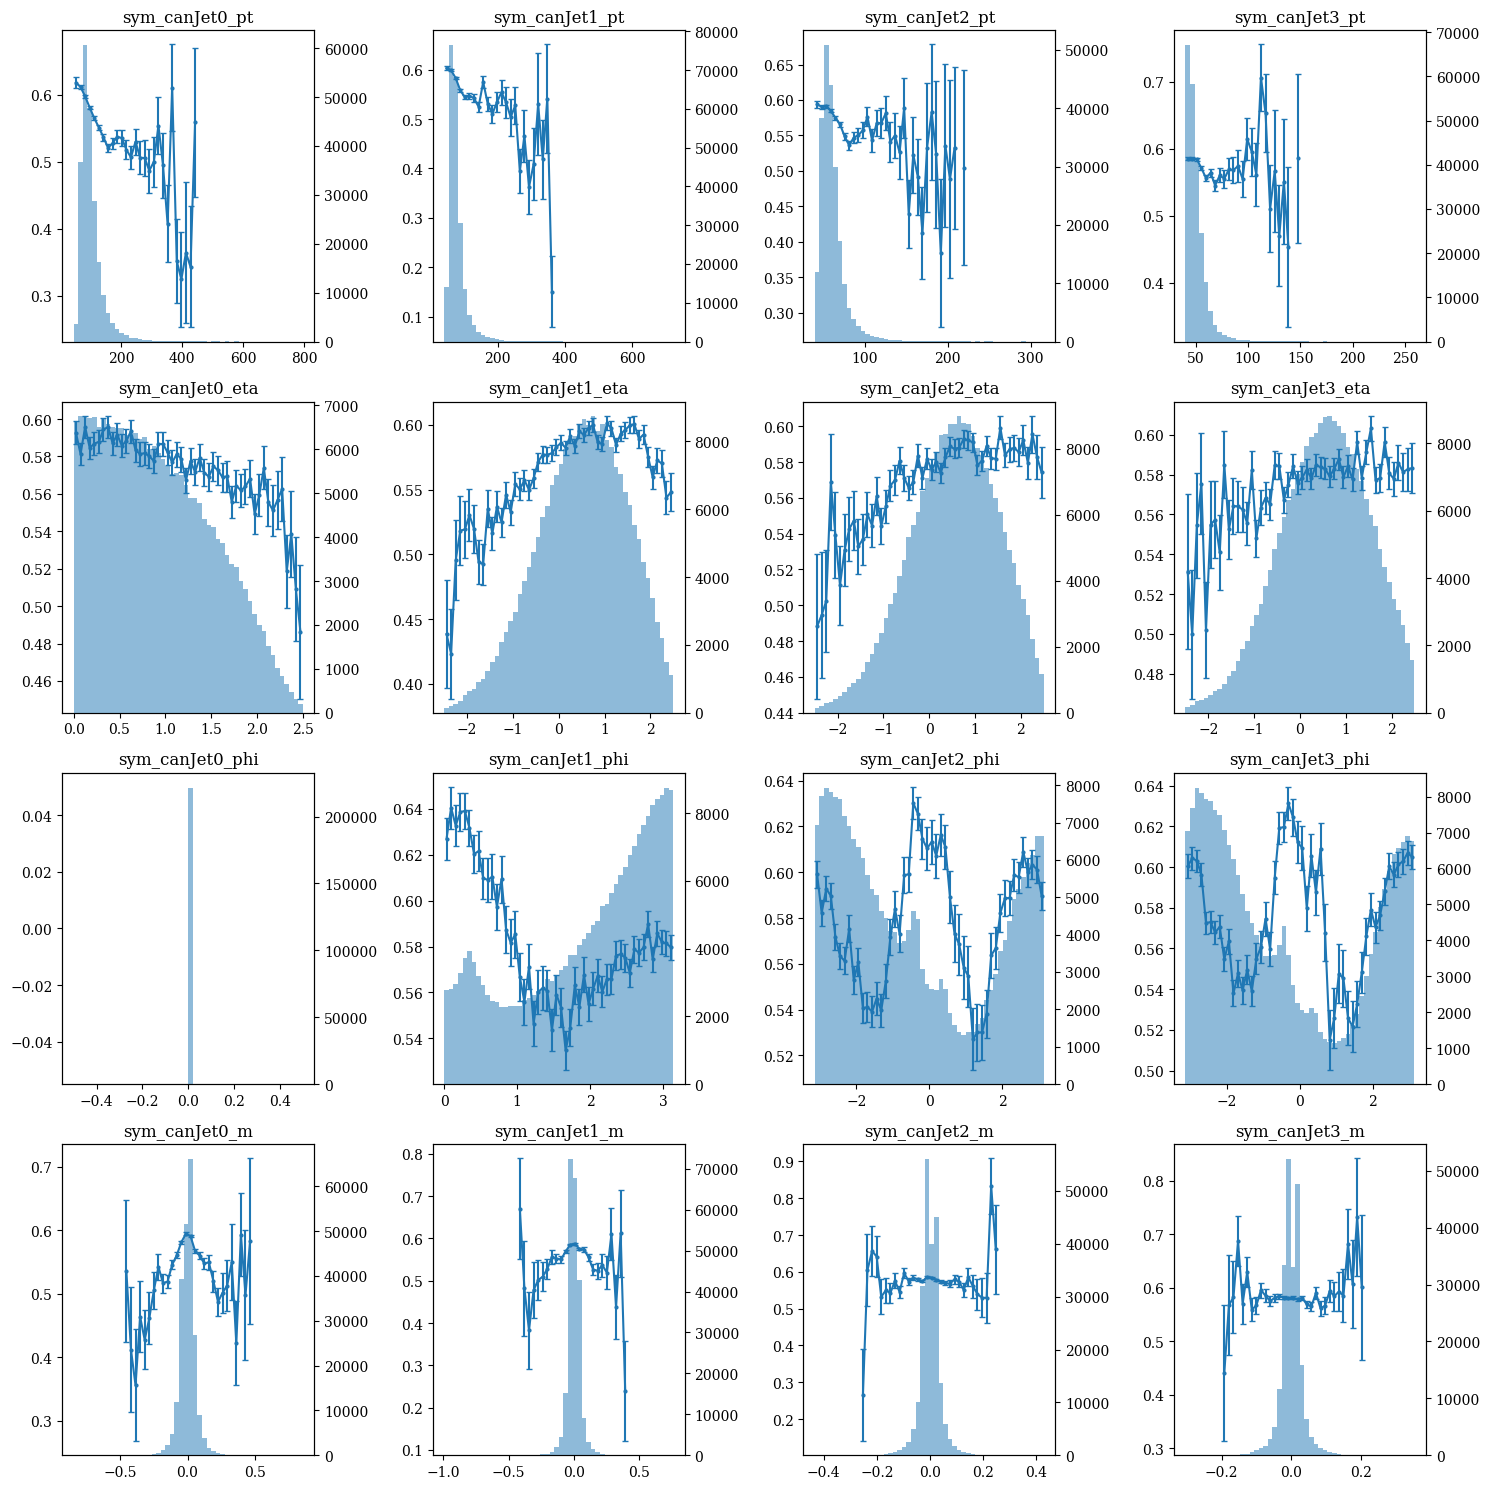

In [25]:
is_4b = clf.df_val["fourTag"].values
weights = clf.df_val[clf.weight].values
bins = 50

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
ax_cnt = 0
for feature in features:
    feature_arr = clf.df_val[feature].values

    feature_min, feature_max = min(feature_arr), max(feature_arr)
    xs = np.linspace(feature_min, feature_max, bins + 1)
    probs_4b_arr = np.zeros(bins)
    err_arr = np.zeros(bins)

    for i in range(bins):
        is_in_bin = (feature_arr >= xs[i]) & (feature_arr < xs[i + 1])

        probs_4b_arr[i] = (is_4b[is_in_bin] * weights[is_in_bin]).sum() / weights[is_in_bin].sum()
        err_arr[i] = np.sqrt((1 - probs_4b_arr[i]) * probs_4b_arr[i] / weights[is_in_bin].sum())

        if is_in_bin.sum() < 1e1:
            probs_4b_arr[i] = np.nan
            err_arr[i] = np.nan
            continue

    current_ax = ax[ax_cnt // 4, ax_cnt % 4]
    current_ax.errorbar((xs[1:] + xs[:-1]) / 2, probs_4b_arr, yerr=err_arr, fmt="o-", capsize=2, markersize=2)
    current_ax.set_title(feature)

    current_ax2 = current_ax.twinx()
    current_ax2.hist(feature_arr, bins=bins, alpha=0.5, weights=weights)

    ax_cnt += 1

plt.tight_layout()
plt.show()
plt.close()

## Gradients

In [26]:
# Get gradients of output of clf.net for the validation set
import torch
from torch.autograd import grad

J_val_, y_val_, w_val_ = clf.dfToTensors(
    clf.df_val, y_true=clf.yTrueLabel)

val_evalLoader = DataLoader(
            dataset=TensorDataset(
                J_val_, y_val_, w_val_
            ),
            batch_size=2**10,
            shuffle=False,
            pin_memory=True,
        )

grads = torch.tensor([])
logits = torch.tensor([])
for J, y, w in val_evalLoader:
    # to device
    J = J.requires_grad_().to(clf.net.device)
    y = y.to(clf.net.device)
    w = w.to(clf.net.device)

    c_score, quadjet_scores = clf.net(J)
    logit = c_score[:, 1] - c_score[:, 0]

    grad_ = grad(logit, J, 
                 create_graph=True, 
                 retain_graph=False,
                 grad_outputs=torch.ones_like(logit))[0].detach().to("cpu")
    
    grads = torch.cat((grads, grad_))
    logit = logit.detach().to("cpu")
    logits = torch.cat((logits, logit))


In [27]:
# save grads value to file
# save logits value to file

grads_filename = "/home/soheuny/HH4bsim/python/classifier/FvT/fvt_fit/archive/sym_resnet_grads.npy"
logits_filename = "/home/soheuny/HH4bsim/python/classifier/FvT/fvt_fit/archive/sym_resnet_logits.npy"

np.save(grads_filename, grads.numpy())
np.save(logits_filename, logits.numpy())

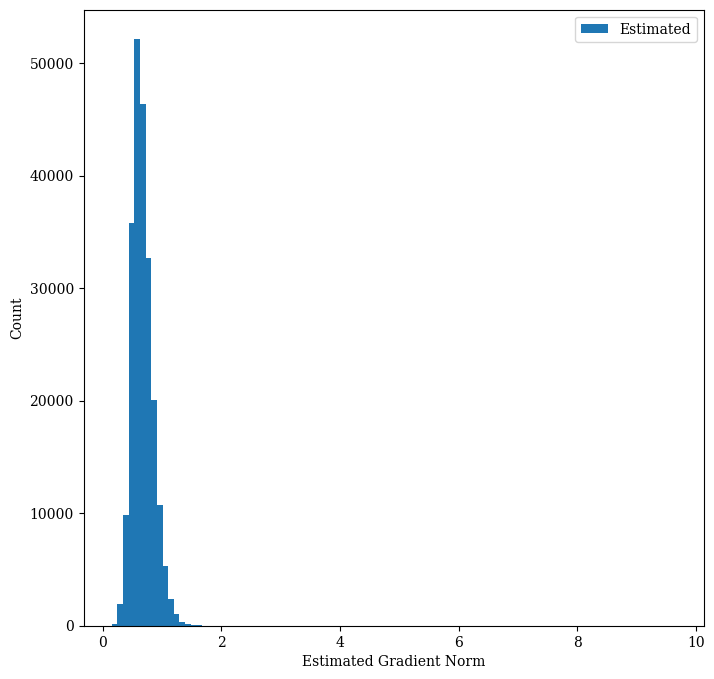

In [28]:
# plot norm of gradients
# load gradient
import matplotlib.pyplot as plt
grads = torch.tensor(np.load(grads_filename))
logits = torch.tensor(np.load(logits_filename))
%matplotlib inline
eps = 1e-12
est_grad_norm = torch.norm(grads, dim=-1) + eps

plt.hist(est_grad_norm.detach().numpy(), bins=100, alpha=1, label="Estimated")
# log scale
plt.xlabel("Estimated Gradient Norm")
plt.ylabel("Count")
plt.legend()
plt.show()
plt.close()

In [29]:
features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

grads_df = pd.DataFrame(grads.numpy(), 
                        columns=features)

grads_df.describe()

# normalization needed?

,sym_canJet0_pt,sym_canJet1_pt,sym_canJet2_pt,sym_canJet3_pt,sym_canJet0_eta,sym_canJet1_eta,sym_canJet2_eta,sym_canJet3_eta,sym_canJet0_phi,sym_canJet1_phi,sym_canJet2_phi,sym_canJet3_phi,sym_canJet0_m,sym_canJet1_m,sym_canJet2_m,sym_canJet3_m
count,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000,219205.000000
mean,-0.001635,-0.000733,-0.000166,0.000766,-0.125085,0.036340,0.026917,0.028136,-0.007338,-0.006206,0.010502,0.007916,0.047213,0.002434,-0.024799,0.048161
std,0.001776,0.002010,0.002325,0.002673,0.257077,0.244528,0.217663,0.195752,0.220370,0.196036,0.188590,0.177651,0.209469,0.132273,0.144771,0.107681
min,-0.060137,-0.089372,-0.207551,-0.091656,-2.516818,-1.290837,-1.278245,-0.841360,-3.222450,-2.469035,-6.718754,-1.263938,-0.921293,-0.856865,-0.798891,-0.645165
25%,-0.002675,-0.001795,-0.001340,-0.000593,-0.303499,-0.139091,-0.122384,-0.100185,-0.189549,-0.152468,-0.135658,-0.129283,-0.054397,-0.077077,-0.124548,-0.015141
50%,-0.001567,-0.000578,0.000078,0.001127,-0.132886,0.039764,0.027806,0.027821,-0.014882,0.004199,0.009551,0.007228,0.068042,0.011698,-0.031294,0.056274
75%,-0.000502,0.000539,0.001288,0.002413,0.063716,0.204942,0.173358,0.154213,0.168000,0.149065,0.155224,0.145431,0.173867,0.081588,0.069346,0.113545
max,0.088894,0.051773,0.091903,0.205587,1.018211,2.415979,1.156607,0.874760,2.886445,3.089878,2.117472,6.896294,0.992897,1.075303,1.003577,1.058189


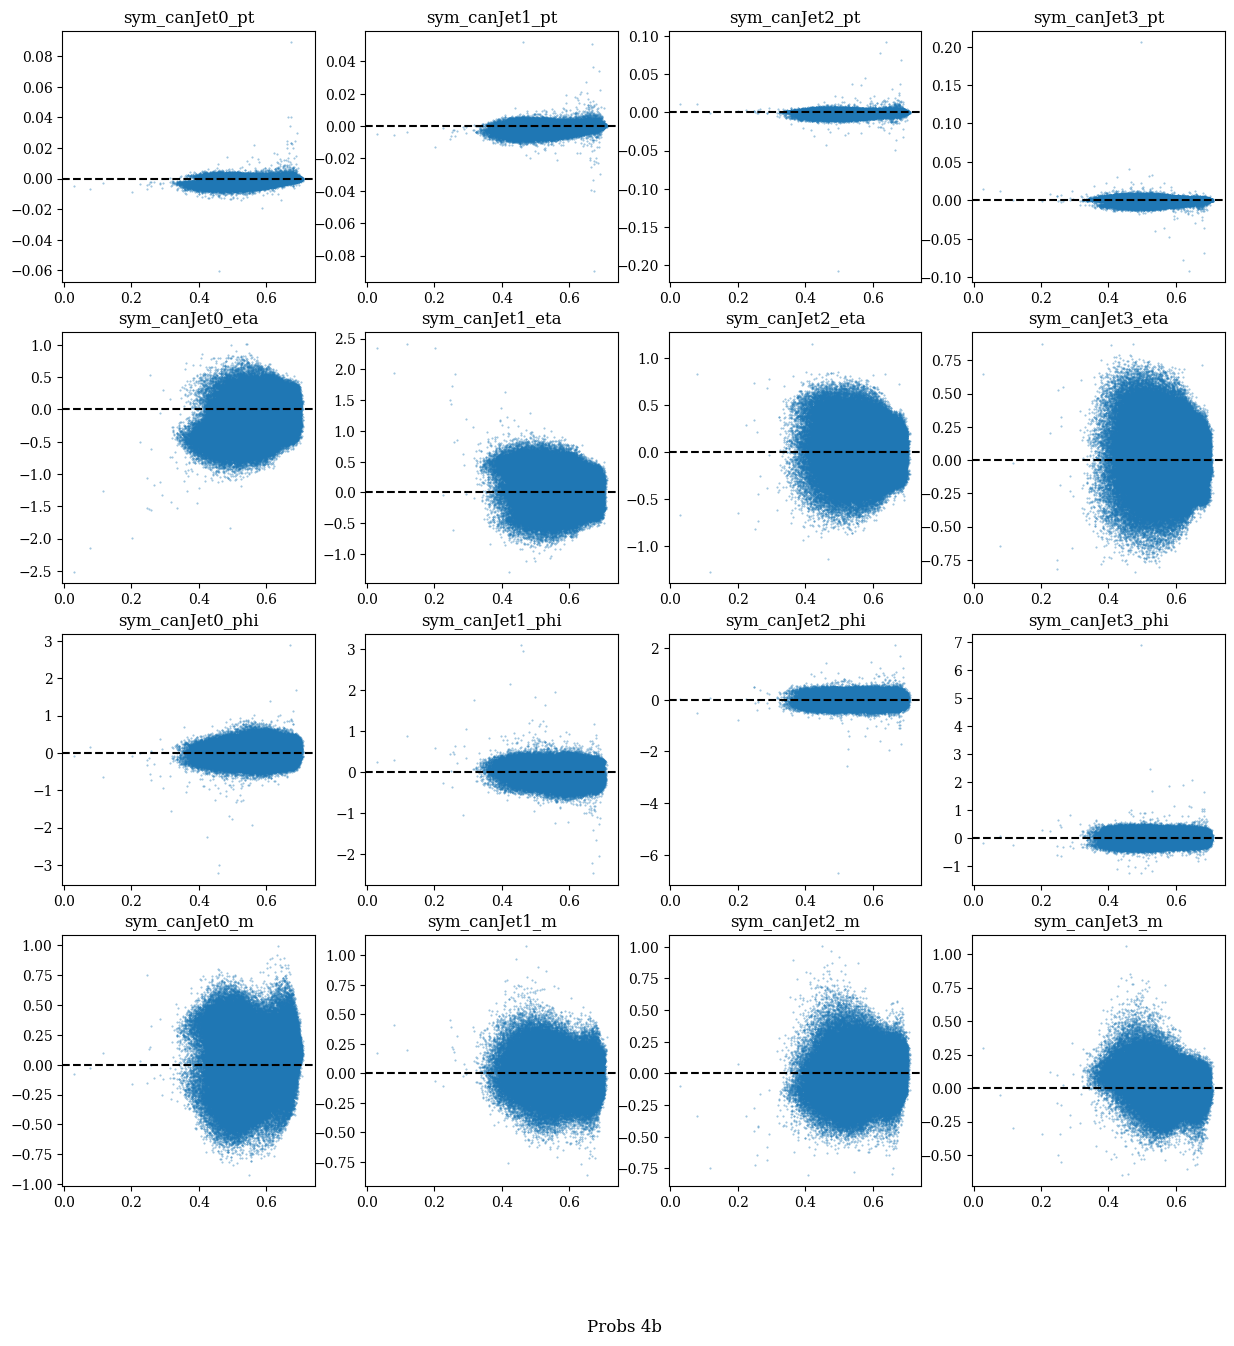

In [30]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
ax_cnt = 0
fig.supxlabel("Probs 4b")
for feature in features:
    ax[ax_cnt // 4, ax_cnt % 4].scatter(probs_4b_sym_resnet, grads_df[feature], alpha=0.5, s=0.2)
    ax[ax_cnt // 4, ax_cnt % 4].set_title(feature)
    ax[ax_cnt // 4, ax_cnt % 4].axhline(0, color="black", linestyle="--")
    ax_cnt += 1

plt.show()
plt.close()

In [31]:
# "normalizing" gradients?
stdev = clf.df_val[features].describe().loc["std"].values
normalized_grads = grads * stdev
normalized_est_grad_norm = torch.norm(normalized_grads, dim=-1) + eps